In [45]:
import pandas as pd
import numpy as np
import cartiflette
import matplotlib.pyplot as plt
import geopandas as gpd
import itertools

from cartiflette import carti_download

# IMPORTATIONS JEUX DE DONNEES

Les jeux de données proviennent du site data.gouv et ont été mis à la disposition du public par l'Autorité Nationale des Jeux, chargée de la régulation des jeux d'argent en France depuis 2010, l'ouverture du marché des paris sportifs à la concurrence (https://fr.wikipedia.org/wiki/Autorit%C3%A9_nationale_des_jeux).

In [46]:
marches = pd.read_csv("https://static.data.gouv.fr/resources/donnees-sur-le-marche-des-jeux-en-ligne-paris-sportifs-hippiques-et-poker-de-2010-a-2024/20251208-095023/open-data-donnees-marche-des-jah-en-ligne-2024.csv", sep=";", encoding="latin-1")

**Description**

Le marché des jeux en ligne s'est ouvert à la concurrence en 2010. Les opérateurs agréés par l'Arjel puis par l'ANJ (Autorité nationale des jeux), depuis sa création en 2020, peuvent proposer des offres de jeux en ligne pour les paris sportifs, les paris hippiques et le poker. La liste des opérateurs agréés est disponible sur le site de l'ANJ. Les opérateurs agréés communiquent régulièrement à l'ANJ les données du marché des jeux en ligne telles que : le nombre de comptes joueurs actifs, les mises, le produit but des jeux (chiffre d'affaires), la répartition des mises se sports, etc.

In [47]:
nb_joueurs = pd.read_csv("https://www.data.gouv.fr/api/1/datasets/r/bee3f217-e4d8-49aa-8985-d66c133de9b0", sep=";", encoding="latin-1")

**Description**

Ce fichier détaille par département la part de joueurs de jeux d'argent en ligne, par segment de jeu, rapportée à sa population adulte en 2024.

In [48]:
interdit = pd.read_csv("https://www.data.gouv.fr/api/1/datasets/r/ac2d4242-4c0f-4415-b88e-558b8e8e5221", sep=";", encoding="latin-1")

**Description**

Répartition géographique des personnes faisant l'objet d'une interdiction volontaire de jeux depuis 2023

L’interdiction volontaire de jeux est une démarche strictement personnelle qui s’effectue en ligne auprès de l’ANJ.

Elle a pour conséquence d’interdire :

d’entrer dans un casino ou un club de jeux,
d’accéder à un site de jeux en ligne agréé par l’ANJ (paris sportifs, paris hippiques et poker),
d’accéder aux jeux de la FDJ et du PMU réalisés avec un compte joueur.

Cette inscription est valable pour une durée de trois ans minimum. Après cette durée, les personnes peuvent demander la levée de cette interdiction.

In [49]:
shp_dep = carti_download(
      values = ["France"],
      crs = 4326,
      borders = "DEPARTEMENT",
      vectorfile_format="topojson",
      simplification=50,
      filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)

**Module de cartographie**

Ce package a été créé par des agents de l'INSEE et il contient des fonds de carte de la France.

## NETTOYAGE DES DONNEES

Le fichier interdit est bizzarement construit, donc il faut modifier sa structure pour voir les données qui nous intéressent, c'est-à-dire une colonne avec les départements, et deux autres avec le nombre d'interdits volontaires en 2023 et en 2024. Les départements sont classés par ordre décroissant du nombre de joueurs interdits volontaires. 

In [50]:
interdit = interdit.drop(columns=[interdit.columns[2], interdit.columns[3], interdit.columns[5]])
interdit = interdit.iloc[2:]
interdit = interdit.iloc[:97]
interdit.columns = ['departement', 'nb_interdit_vol_2023', 'nb_interdit_vol_2024']
interdit.head()

,departement,nb_interdit_vol_2023,nb_interdit_vol_2024
2,13,2734,3602
3,59,2605,3435
4,06,2430,3150
5,69,1778,2367
6,83,1734,2300


Les clés de département entre les différents jeux de données sont différentes, donc il faut harmoniser au mieux pour avoir des cartes précises.

In [51]:
dep_nb_joueurs = set(nb_joueurs['Numéro du Département'].dropna().unique())
dep_interdit = set(interdit['departement'].dropna().unique())
dep_shp = set(shp_dep['INSEE_DEP'].dropna().unique())

dept_numbers = sorted(set(dep_nb_joueurs | dep_interdit | dep_shp))

comparison_data = {
    'Numéro Département': dept_numbers,
    'nb_joueurs': [d in dep_nb_joueurs for d in dept_numbers],
    'interdit': [d in dep_interdit for d in dept_numbers],
    'dep_clean (cartographie)': [d in dep_shp for d in dept_numbers]
}

comparison_df = pd.DataFrame(comparison_data)

comparison_df_filtered = comparison_df[
    ~(comparison_df['nb_joueurs'] & comparison_df['interdit'] & comparison_df['dep_clean (cartographie)'])
]

# Afficher le tableau
print("TABLEAU COMPARATIF DES INCLUSIONS PAR DATAFRAME")
print("(Affichage uniquement des départements avec incohérences)")
print("=" * 80)
print(comparison_df_filtered.to_string(index=False))
print("\n")

TABLEAU COMPARATIF DES INCLUSIONS PAR DATAFRAME
(Affichage uniquement des départements avec incohérences)
Numéro Département  nb_joueurs  interdit  dep_clean (cartographie)
                01       False      True                      True
                02       False      True                      True
                03       False      True                      True
                04       False      True                      True
                05       False      True                      True
                06       False      True                      True
                07       False      True                      True
                08       False      True                      True
                09       False      True                      True
                 1        True     False                     False
                 2        True     False                     False
                20       False      True                     False
 20 (anciennement)     

Le premier élément de ce tableau nous indique qu'il faudra passer toutes les données en **numeric** pour pouvoir *merge* intelligemment par la suite. Ensuite, pour la **Corse**, trois libellés sont possibles : 20, 20 (anciennement) et 2A/2B, comme seul le *dataframe* de cartographie fait la distinction, on garde la dénomination 20 en regroupant les deux départements en *mergeant* les coordonnées cartographiques de deux départements. La question est plus complexe pour les **départements d'outre-mer** : interdit regroupe tous les départements d'outre-mer dans le numéro 97, et fait une distinction avec les autres territoires d'outre-mer du numéro 98, tandis que les autres ont des données pour chaque DOM, mais pas pour les COM. On décide de ne pas essayer d'harmoniser ces données.

In [52]:
nb_joueurs['Numéro du Département'] = nb_joueurs['Numéro du Département'].replace('20 (anciennement)', '20')
nb_joueurs['Numéro du Département'] = pd.to_numeric(nb_joueurs['Numéro du Département'], errors='coerce')
nb_joueurs['Numéro du Département'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95, 971, 972, 973, 974, 976])

In [53]:
interdit['departement'] = pd.to_numeric(interdit['departement'], errors='coerce')
interdit['departement'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98])

In [54]:
dep = shp_dep[['INSEE_DEP', 'LIBELLE_DEPARTEMENT', 'geometry']].copy()
dep['INSEE_DEP'] = dep['INSEE_DEP'].replace({'2A': '20', '2B': '20'})
dep['INSEE_DEP'] = pd.to_numeric(dep['INSEE_DEP'], errors='coerce')

dep_clean = dep.dropna(subset=['geometry', 'INSEE_DEP']).copy()

dep_clean['geometry'] = dep_clean.geometry.make_valid()

dep_clean = dep_clean.dissolve(by='INSEE_DEP', aggfunc='first')
dep_clean = dep_clean.reset_index()

dep_clean['INSEE_DEP'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95, 971, 972, 973, 974, 976])

In [55]:
joueurs_tomerge = nb_joueurs.merge(interdit, left_on='Numéro du Département', right_on='departement', how='outer')

In [56]:
joueurs_geo = joueurs_tomerge.merge(dep_clean, left_on='Numéro du Département', right_on='INSEE_DEP', how='outer')

Finalement, on renomme les variables et on met tout en *numeric*, sauf les coordonnées géographiques, et on calcule les densités pour enrichir l'information.

In [57]:
joueurs_geo.rename(columns={
    'Numéro du Département': 'num_dep1',
    'Département': 'nom_dep',
    'Nombre de Joueurs de Poker': 'nb_joueurs_po',
    'Nombre de joueurs de Paris Hippiques': 'nb_joueurs_ph',
    'Nombre de Joueurs de Paris Sportifs': 'nb_joueurs_ps',
    'Nombre de Joueurs Uniques tous segments': 'nb_joueurs_uniques',
    'Population adulte INSEE par Département': 'pop',
    'Densité Poker': 'densite_po',
    'Densité Paris Hippiques': 'densite_ph',
    'Densité Paris Sportifs': 'densite_ps',
    'departement': 'num_dep2',
    }, inplace=True)

In [58]:
cols = ['densite_po', 'densite_ps', 'densite_ph']

for col in cols:
    joueurs_geo[col] = pd.to_numeric(
        joueurs_geo[col]
            .astype(str)
            .str.replace(',', '.', regex=False)
            .str.rstrip('%'),
        errors='coerce'
    ) / 100

In [59]:
# On complète les autres densités
joueurs_geo['densite_joueurs_uniques'] = joueurs_geo['nb_joueurs_uniques'] / joueurs_geo['pop']

joueurs_geo['nb_interdit_vol_2023'] = pd.to_numeric(joueurs_geo['nb_interdit_vol_2023'], errors='coerce')
joueurs_geo['nb_interdit_vol_2024'] = pd.to_numeric(joueurs_geo['nb_interdit_vol_2024'], errors='coerce')

joueurs_geo['densite_interdit_2023'] = joueurs_geo['nb_interdit_vol_2023'] / joueurs_geo['pop']
joueurs_geo['densite_interdit_2024'] = joueurs_geo['nb_interdit_vol_2024'] / joueurs_geo['pop']

joueurs_geo['joueurs_pour_interdit'] = joueurs_geo['nb_joueurs_uniques'] / joueurs_geo['nb_interdit_vol_2024']

Pour la base de données des marchés, un peu de travail est à réaliser aussi. En particulier, il convient de transposer le *dataframe* afin d'avoir les variables en colonnes plutôt qu'en lignes. Puis, on renomme les colonnes pour simplifier les clés, et on passe toutes les données en numeric (notamment en enlevant les %) afin de créer de nouvelles colonnes à partir de celles existantes.

In [60]:
marches = marches.iloc[:26]

# Transposer le dataframe : années en lignes, catégories en colonnes
marches = marches.set_index('Catégorie/Année').T
marches.index.name = 'Année'
marches['year'] = list(range(2010, 2025))
marches = marches.reset_index()

marches = marches.rename(columns={'Nombre dopérateurs' : 'nb_op',
                                  'Nombre dagréments' : 'nb_agrements',
                                  'Nombre agréments paris sportifs' : 'nb_agrements_ps',
                                  'Nombre agréments paris hippiques' : 'nb_agrements_ph',
                                  'Nombre agréments poker' : 'nb_agrements_po',
                                  'Nombre de comptes joueurs actifs total (en milliers)' : 'CJA_total',
                                  'Nombre CJA Paris sportifs (en milliers)' : 'CJA_ps',
                                  'Nombre CJA Paris hippiques (en milliers)' : 'CJA_ph',
                                  'Nombre CJA Poker (en milliers)' : 'CJA_po',
                                  'Nombre de joueurs uniques' : 'nb_joueurs_uniques',
                                  'Mises paris sportifs (en M)' : 'mises_ps',
                                  'Mises paris hippiques (en M)' : 'mises_ph',
                                  'PBJ paris sportifs (en M)' : 'PBJ_ps',
                                  'PBJ paris hippiques (en M)' : 'PBJ_ph',
                                  'PBJ poker (en M)' : 'PBJ_po',
                                  'Budget marketing médias (en M)' : 'budget_marketing',
                                  'Part hommes PS' : 'part_hommes_ps',
                                  'Part femmes PS' : 'part_femmes_ps',
                                  'Part mises football' : 'part_mises_football',
                                  'Part mises tennis' : 'part_mises_tennis',
                                  'Part mises basketball' : 'part_mises_basketball',
                                  'Part mises rugby' : 'part_mises_rugby',
                                  'Part hommes PH' : 'part_hommes_ph',
                                  'Part femmes PH' : 'part_femmes_ph',
                                  'Part hommes PO' : 'part_hommes_po',
                                  'Part femmes PO' : 'part_femmes_po'})


cols = ['part_hommes_ps', 'part_femmes_ps', 'part_hommes_ph', 'part_femmes_ph', 'part_hommes_po', 'part_femmes_po', 'part_mises_football', 'part_mises_tennis', 'part_mises_basketball', 'part_mises_rugby']

for col in cols:
    marches[col] = pd.to_numeric(
        marches[col].astype(str).str.rstrip('%'), 
        errors='coerce'
    ) / 100

marches = marches.drop(['Année'], axis=1).apply(pd.to_numeric, errors='coerce')

marches.head()

Catégorie/Année,nb_op,nb_agrements,nb_agrements_ps,nb_agrements_ph,nb_agrements_po,CJA_total,CJA_ps,CJA_ph,CJA_po,nb_joueurs_uniques,...,part_femmes_ps,part_hommes_ph,part_femmes_ph,part_hommes_po,part_femmes_po,part_mises_football,part_mises_tennis,part_mises_basketball,part_mises_rugby,year
0,35,48,15,8,25,2058,819,365,1188,NaN,...,0.08,0.81,0.19,0.91,0.09,NaN,NaN,NaN,NaN,2010
1,32,48,16,9,23,2325,705,502,1686,NaN,...,0.08,0.80,0.20,0.89,0.11,NaN,NaN,NaN,NaN,2011
2,30,33,9,8,16,2229,765,509,1713,NaN,...,0.08,0.81,0.19,0.88,0.12,0.59,0.19,0.08,0.03,2012
3,21,30,9,8,13,2142,842,496,1240,NaN,...,0.08,0.81,0.19,0.88,0.12,0.61,0.19,0.09,0.03,2013
4,16,31,11,8,12,2320,1142,488,1157,NaN,...,0.07,0.83,0.17,0.89,0.11,0.63,0.16,0.10,0.03,2014


In [ ]:
# La part des mises consacrées aux autres sports
marches['part_mises_autres_sports'] = 1 - (marches['part_mises_football'] + marches['part_mises_tennis'] + marches['part_mises_basketball'] + marches['part_mises_rugby'])

# Le PBJ total
marches['PBJ_total'] = marches['PBJ_ps'] + marches['PBJ_ph'] + marches['PBJ_po']

# A partir des mises et des parts, on calcule les mises par sport et par genre
cols_ps = ['part_hommes_ps', 'part_femmes_ps', 'part_mises_football', 'part_mises_tennis', 'part_mises_basketball', 'part_mises_rugby', 'part_mises_autres_sports']

for col in cols_ps:
    cible = col.replace('part_mises_', 'mises_', 1)
    marches[cible] = marches[col] * marches['mises_ps']

for col in ['part_hommes_ph', 'part_femmes_ph']:
    cible = col.replace('part_mises_', 'mises_', 1)
    marches[cible] = marches[col] * marches['mises_ph']

# On calcule des ratios utiles
# Le nombre de comptes joueurs actifs par rapport au produit brut de jeu
# C'est-à-dire combien de joueurs génèrent en moyenne un euro de PBJ
marches['CJA_PBJ_PS'] = marches['CJA_ps'] / marches['PBJ_ps']
marches['CJA_PBJ_PH'] = marches['CJA_ph'] / marches['PBJ_ph']
marches['CJA_PBJ_PO'] = marches['CJA_po'] / marches['PBJ_po']
marches['CJA_PBJ_tot'] = marches['CJA_total'] / marches['PBJ_total']

# Le montant de mises par compte joueur actif
marches['Mises_per_CJA_ps'] = marches['mises_ps'] / marches['CJA_ps']
marches['Mises_per_CJA_ph'] = marches['mises_ph'] / marches['CJA_ph']

# Combien faut-il de mises pour générer un euro de PBJ ?
marches['Mises_PBJ_ps'] = marches['mises_ps'] / marches['PBJ_ps']
marches['Mises_PBJ_ph'] = marches['mises_ph'] / marches['PBJ_ph']   

# VISUALISATION DES DONNEES

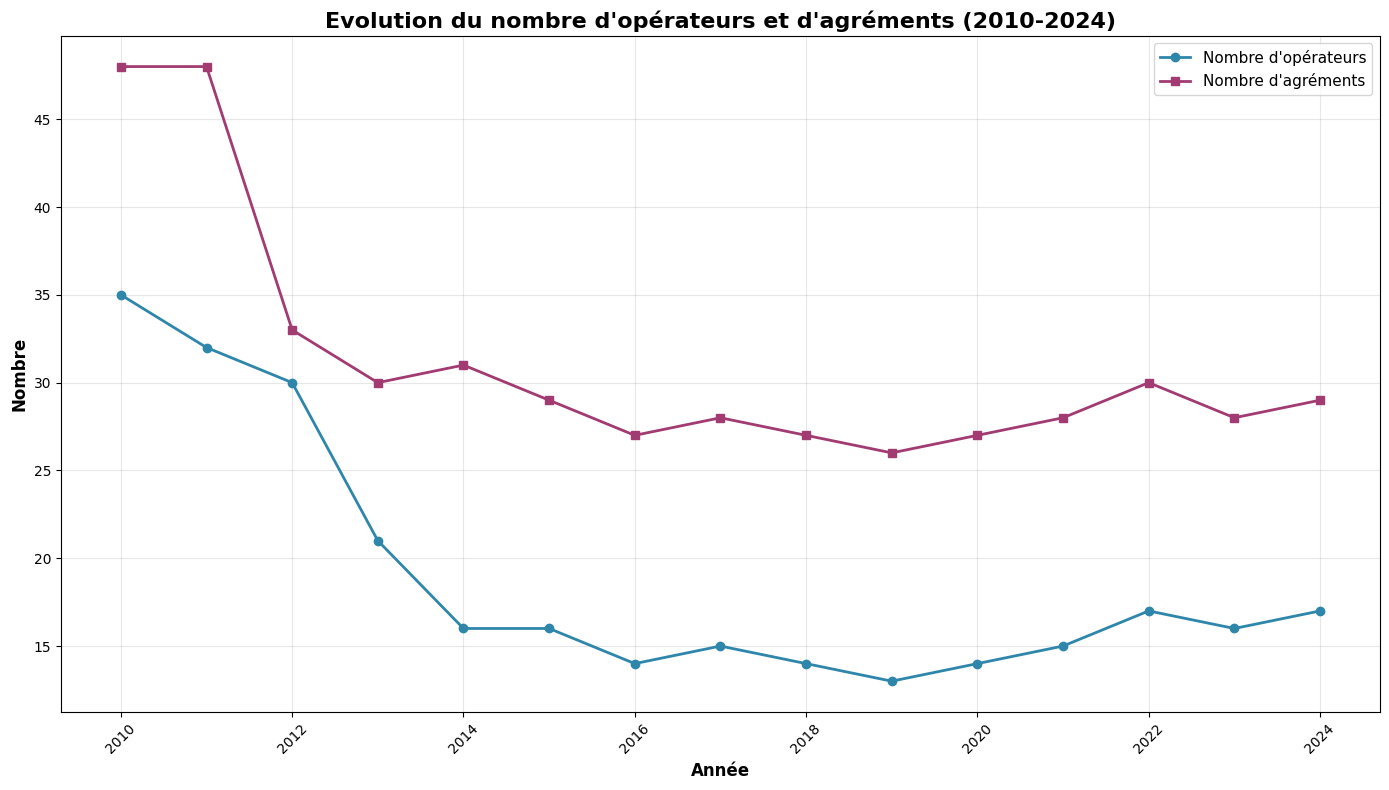

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(marches['year'], marches['nb_op'], marker='o', linewidth=2, label="Nombre d'opérateurs", color='#2E86AB')
ax.plot(marches['year'], marches['nb_agrements'], marker='s', linewidth=2, label="Nombre d'agréments", color='#A23B72')

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre', fontsize=12, fontweight='bold')
ax.set_title("Evolution du nombre d'opérateurs et d'agréments (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Les agréments concernent les autorisations délivrées par l'ANJ pour qu'une entreprise offre des marchés de jeux d'argent, qui ne sont pas des jeux de hasard, et les opérateurs sont les entreprises qui ont le droit d'utiliser cet agrément. Il y a plus d'agréments que d'opérateurs, car plusieurs opérateurs ont un agrément dans plusieurs secteurs, c'est le cas de Parions Sport En Ligne qui propose des marchés en paris sportifs, en paris hippiques et en poker.

En 15 ans, le nombre d'agréments et le nombre d'opérateurs ont suivi la même tendance, à savoir une baisse de 2010 à 2013/2014 puis un équilibre autour de 15 opérateurs pour un peu plus de 25 agréments, et à partir de 2018 une augmentation lente avec environ 1 opérateur de plus chaque année. 

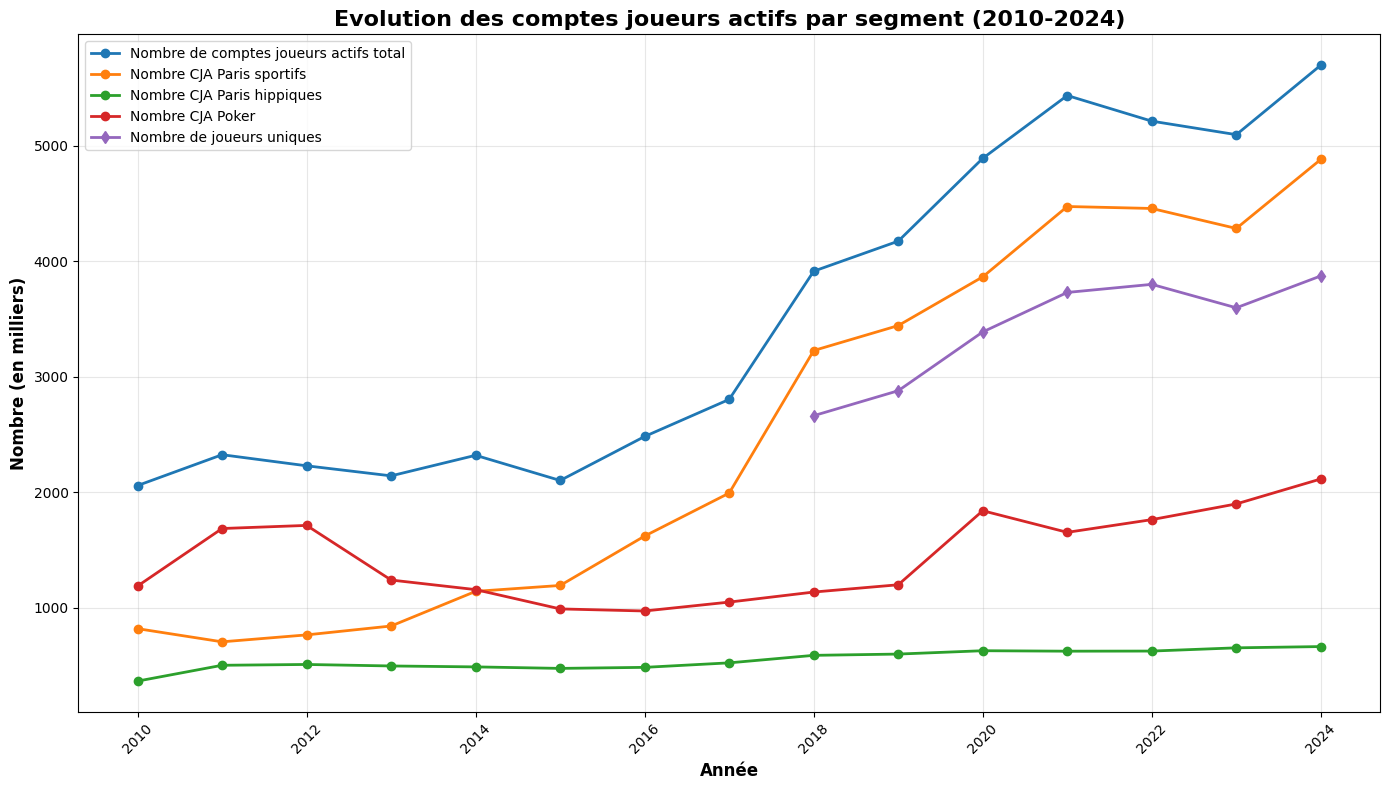

In [63]:
# Comptes joueurs actifs
categories_cja = [
    'CJA_total',
    'CJA_ps',
    'CJA_ph',
    'CJA_po',
    'nb_joueurs_uniques'
]

labels_cja = [
    'Nombre de CJA total',
    'Nombre CJA Paris sportifs',
    'Nombre CJA Paris hippiques',
    'Nombre CJA Poker',
    'Nombre de joueurs uniques'
]

marker_cja = ['o', 'o', 'o', 'o', 'd']

fig, ax = plt.subplots(figsize=(14, 8))

for categorie in categories_cja:
    valeurs = marches[categorie].values
    ax.plot(marches['year'], valeurs, marker=marker_cja[categories_cja.index(categorie)], linewidth=2, label=labels_cja[categories_cja.index(categorie)])

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre (en milliers)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des comptes joueurs actifs par segment (2010-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Au niveau des joueurs, le nombre de CJA pour les paris sportifs a augmenté de manière continue depuis 2014, au moment où le marché a semblé se stabiliser sur les opérateurs, tandis que le nombre de joueurs de poker connaît une évolution contrastée, c'est-à-dire une baisse de ses nombres de comptes entre 2011 et 2016, puis une augmentation progressive jusqu'aujourd'hui, et enfin, le nombre de joueurs de paris hippiques est constant tout au long de la période.

Il est intéressant de noter que de la même manière que les opérateurs officient sur plusieurs segments des jeux de hasard, les joueurs sont aussi présents sur ces segments, en voyant que le nombre de CJA pour les paris sportifs est supérieur au nombre de joueurs uniques. 

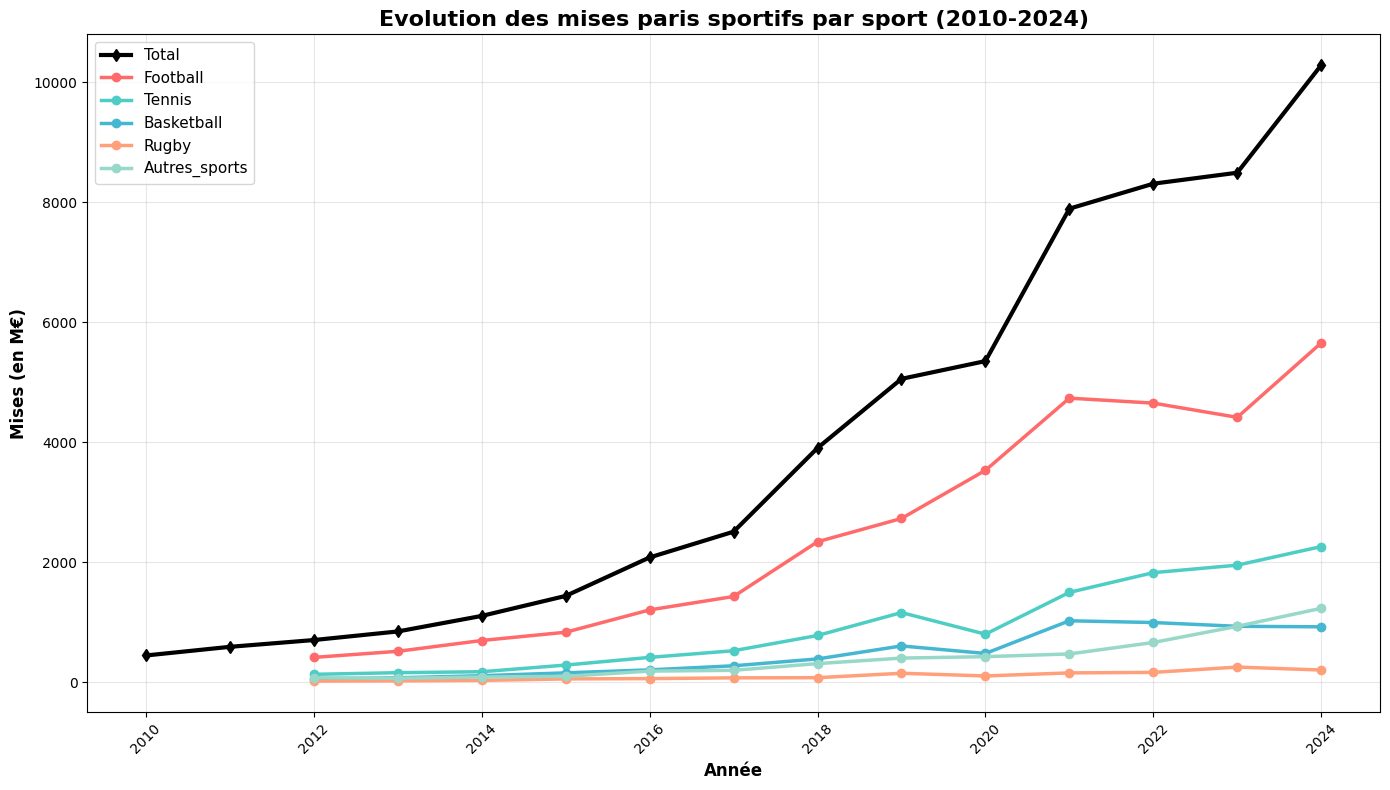

In [65]:
# Mises par sport
sports = ['football', 'tennis', 'basketball', 'rugby', 'autres_sports']
couleurs_sports = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

fig, ax = plt.subplots(figsize=(14, 8))

valeurs_total = marches['mises_ps'].values
ax.plot(marches['year'], valeurs_total, marker='d', linewidth=3, label='Total', color='#000000', zorder=10)

for idx, sport in enumerate(sports):
    categorie = f'mises_{sport}'
    valeurs = marches[categorie].values
    ax.plot(marches['year'], valeurs, marker='o', linewidth=2.5, label=sport.capitalize(), color=couleurs_sports[idx])

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Mises (en M€)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des mises paris sportifs par sport (2010-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En lien avec l'augmentation totale du nombre de joueurs, le montant total des mises a aussi considérablement augmenté en 15 ans, dépassant en 2024 10 milliards d'euros tous segments confondus, bien que cette augmentation soit largement soutenue par les mises sur le football. 

Il est intéressant de noter sur ce graphique que pour la première fois en 2023, les mises sur les autres sports dépassent celles sur le basketball et celles sur le rugby, ce qui montre l'attrait de nouveaux marchés sur des sports moins traditionnels et moins visionnés.

De plus, le football a eu l'air de ne pas souffrir de l'année 2020, à l'inverse des autres sports, en particulier le tennis, dont les compétitions ont été arrêtées pendant le confinement. On peut voir ce constat, sur le graphique juste en dessous qui empile les aires de chaque sport.

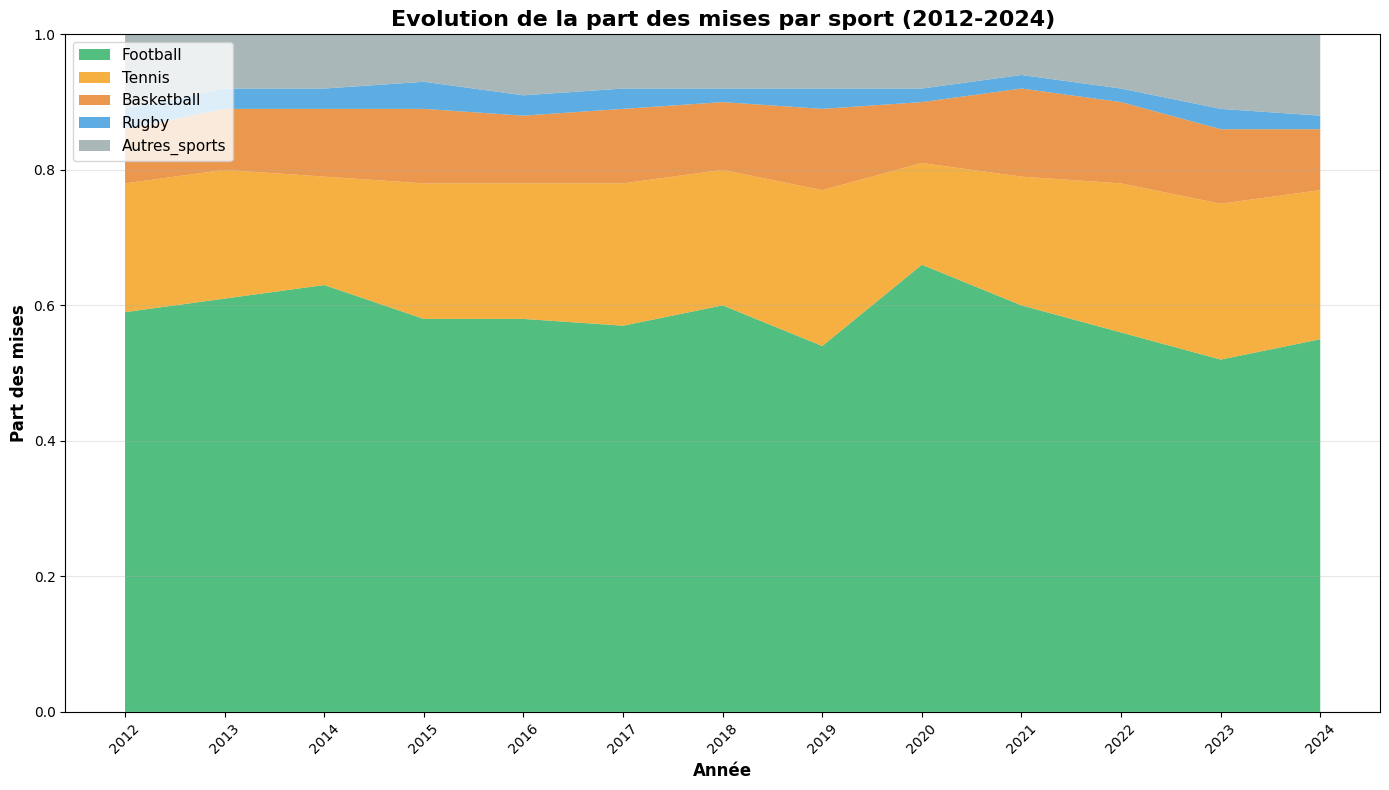

In [71]:
couleurs_sports = ['#27ae60', '#f39c12', '#e67e22', '#3498db', '#95a5a6']

# Filtrer les années à partir de 2012
marches_recent = marches[marches['year'] >= 2012].copy()
x_vals = np.arange(len(marches_recent['year']))

fig, ax = plt.subplots(figsize=(14, 8))

data_proportions = [marches_recent[f'part_mises_{sport}'].values for sport in sports]
ax.stackplot(
    x_vals,
    data_proportions,
    labels=[sport.capitalize() for sport in sports],
    colors=couleurs_sports,
    alpha=0.8
)

ax.set_xticks(x_vals)
ax.set_xticklabels(marches_recent['year'], rotation=45)
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Part des mises', fontsize=12, fontweight='bold')
ax.set_title('Evolution de la part des mises par sport (2012-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

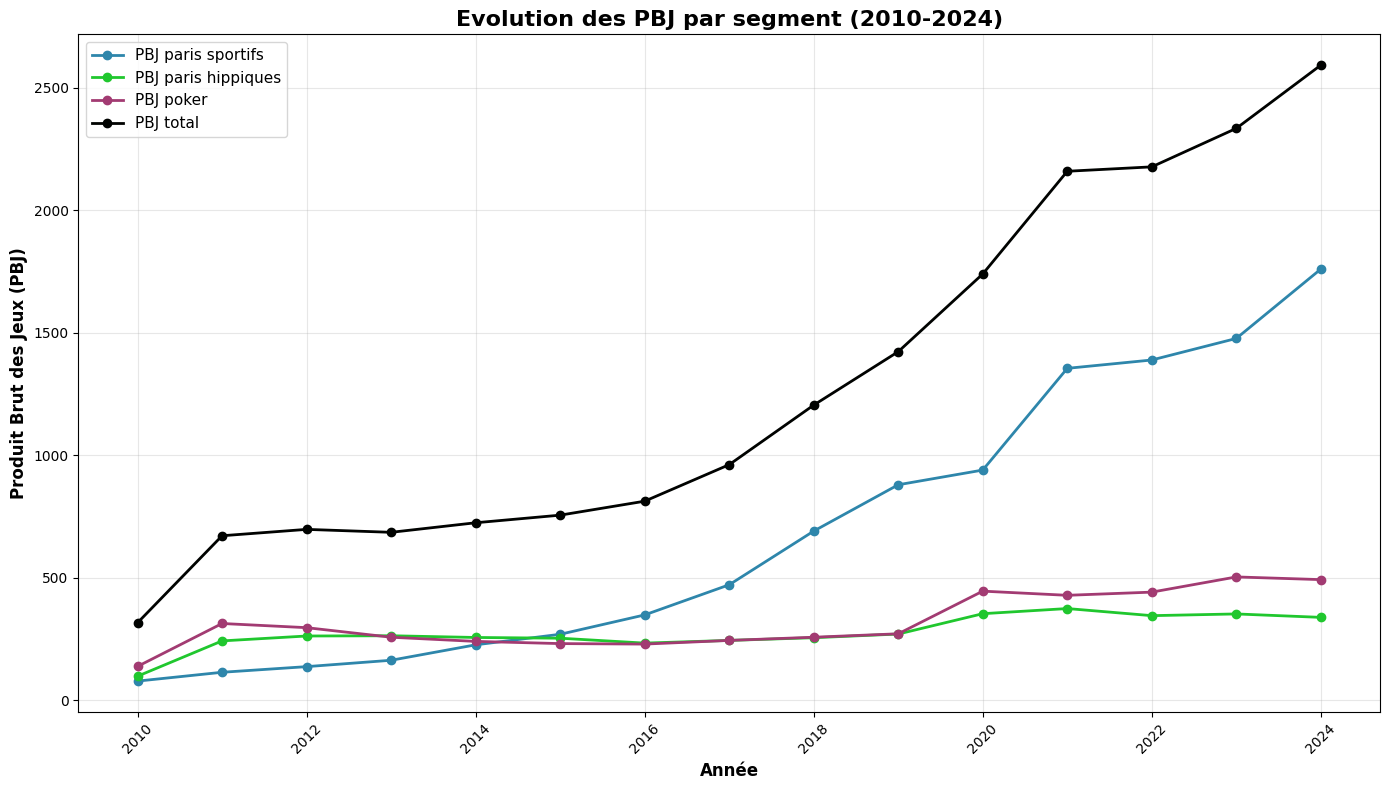

In [74]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(marches['year'], marches['PBJ_ps'], marker='o', linewidth=2, label="PBJ paris sportifs", color='#2E86AB')
ax.plot(marches['year'], marches['PBJ_ph'], marker='o', linewidth=2, label="PBJ paris hippiques", color="#20C72E")
ax.plot(marches['year'], marches['PBJ_po'], marker='o', linewidth=2, label="PBJ poker", color='#A23B72')
ax.plot(marches['year'], marches['PBJ_total'], marker='o', linewidth=2, label="PBJ total", color="#000200")

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Produit Brut des Jeux (PBJ)', fontsize=12, fontweight='bold')
ax.set_title("Evolution des PBJ par segment (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Les PBJ confirment l'essor du marché des jeux de hasard après la période de stabilisation entre l'ouverture à la concurrence en 2010 et l'année 2015 à peu près, et la croissance est largement soutenue, encore une fois, par les paris sportifs. En effet, entre 2010 et 2014 les PBJ des paris hippiques sont supérieurs à ceux des paris sportifs, et ils sont en 2024 presque 4 fois inférieurs

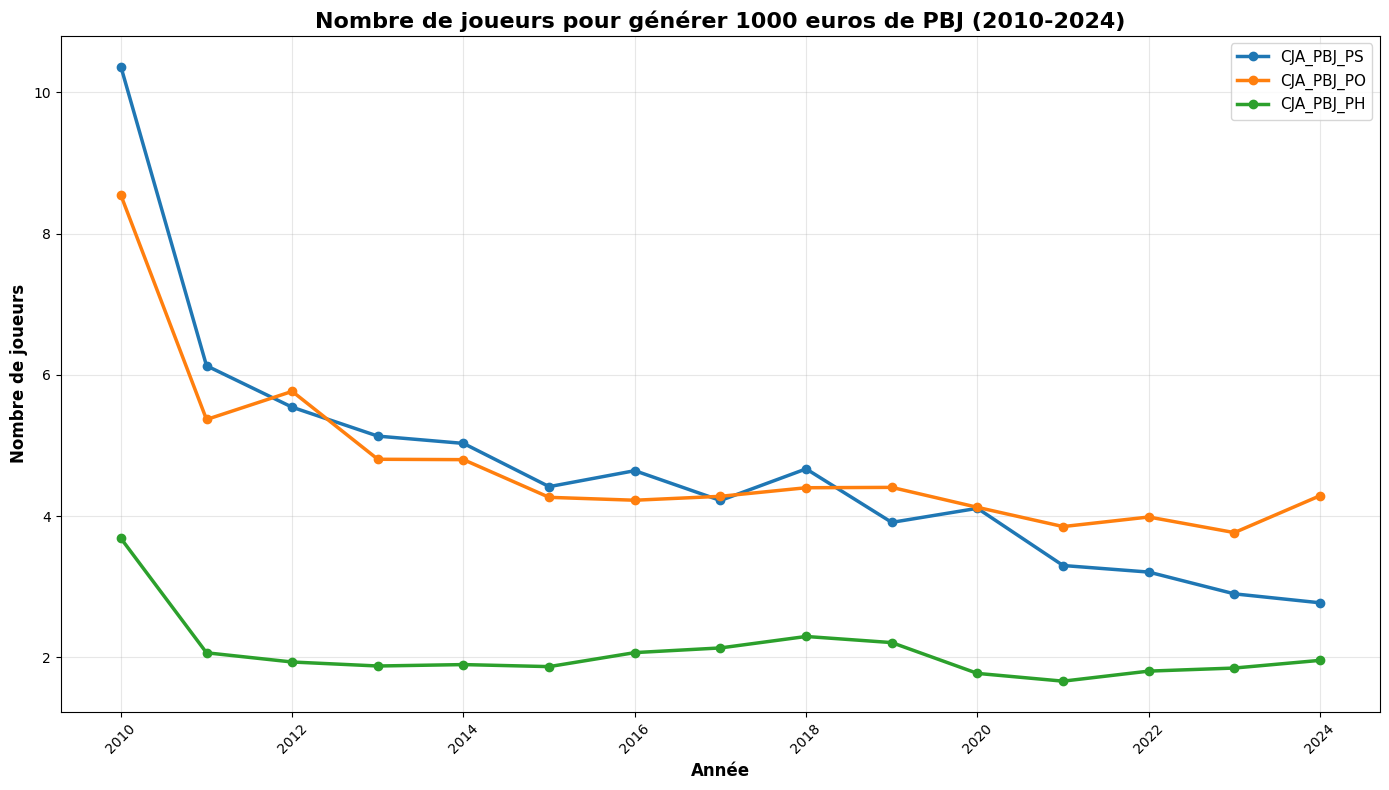

In [82]:
cols = ['CJA_PBJ_PS', 'CJA_PBJ_PO', 'CJA_PBJ_PH']
couleurs = ["#541BE5", "#E62107", "#0EE15F"]

fig, ax = plt.subplots(figsize=(14, 8))

for col in cols:
    valeur = marches[col].values
    ax.plot(marches['year'], valeur, label=col, marker='o', linewidth=2.5)

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("Nombre de joueurs", fontsize=12, fontweight='bold')
ax.set_title("Nombre de joueurs pour générer 1000 euros de PBJ (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Réfléchir au commentaire de ce graphique

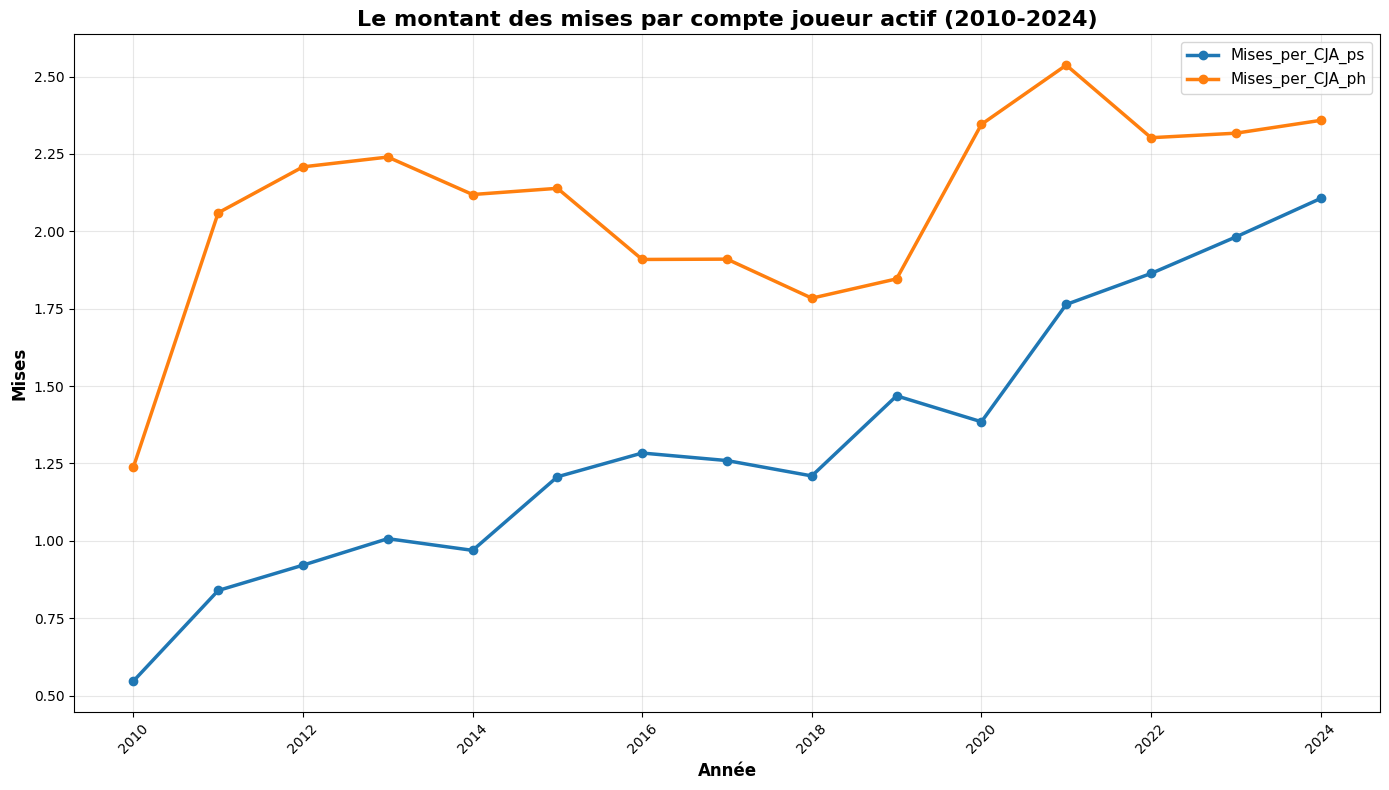

In [78]:
cols = ['Mises_per_CJA_ps', 'Mises_per_CJA_ph']
couleurs = ["#541BE5", "#0EE15F"]

fig, ax = plt.subplots(figsize=(14, 8))

for col in cols:
    valeur = marches[col].values
    ax.plot(marches['year'], valeur, label=col, marker='o', linewidth=2.5)

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("Mises", fontsize=12, fontweight='bold')
ax.set_title("Le montant des mises par compte joueur actif (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Pareil, revoir le commentaire de ce graphique et ce que ça mesure aussi 

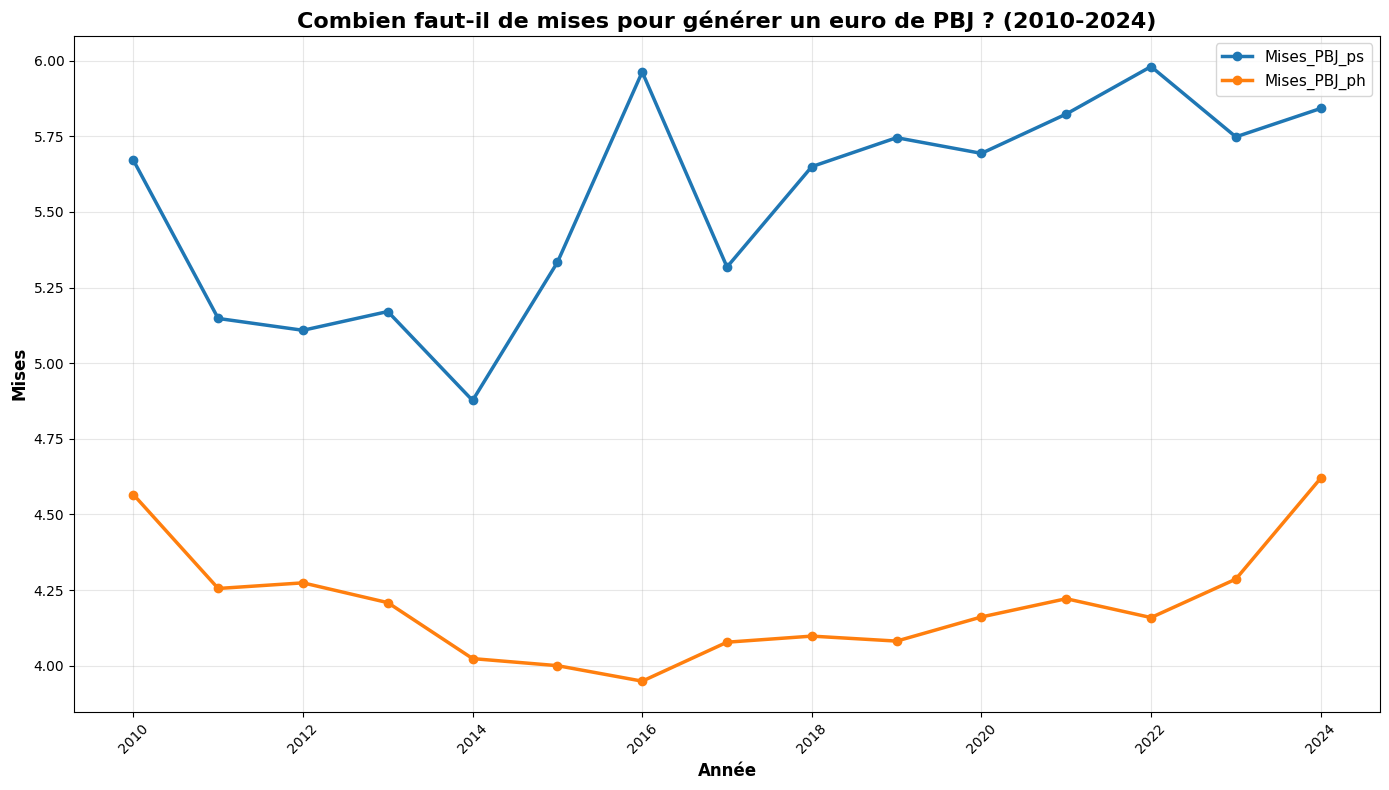

In [79]:
cols = ['Mises_PBJ_ps', 'Mises_PBJ_ph']
couleurs = ["#541BE5", "#0EE15F"]

fig, ax = plt.subplots(figsize=(14, 8))

for col in cols:
    valeur = marches[col].values
    ax.plot(marches['year'], valeur, label=col, marker='o', linewidth=2.5)

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("Mises", fontsize=12, fontweight='bold')
ax.set_title("Combien faut-il de mises pour générer un euro de PBJ ? (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ajouter le graphique sur les mises hommes et femmes

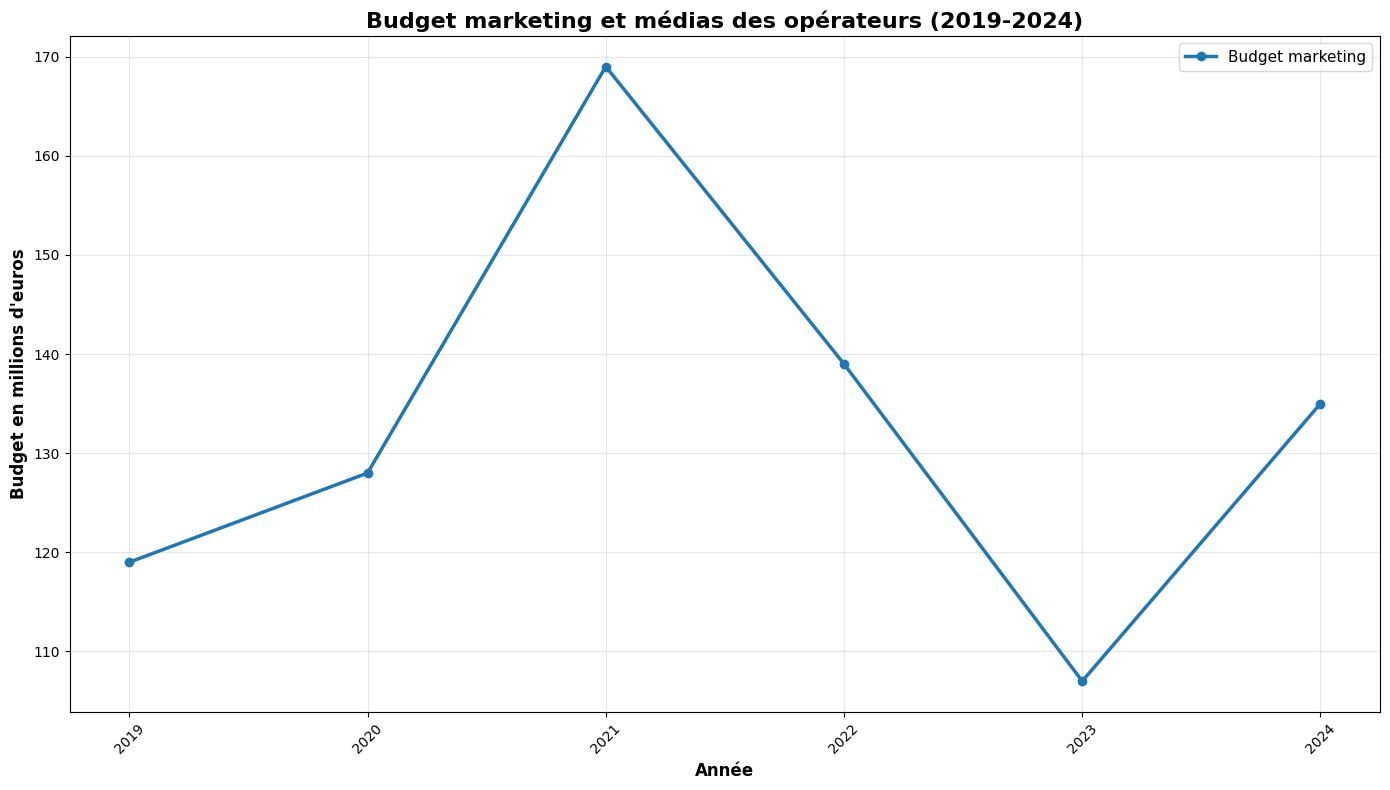

In [81]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(marches['year'], marches['budget_marketing'], label='Budget marketing', marker='o', linewidth=2.5)

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("Budget en millions d'euros", fontsize=12, fontweight='bold')
ax.set_title("Budget marketing et médias des opérateurs (2019-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# A TRIER

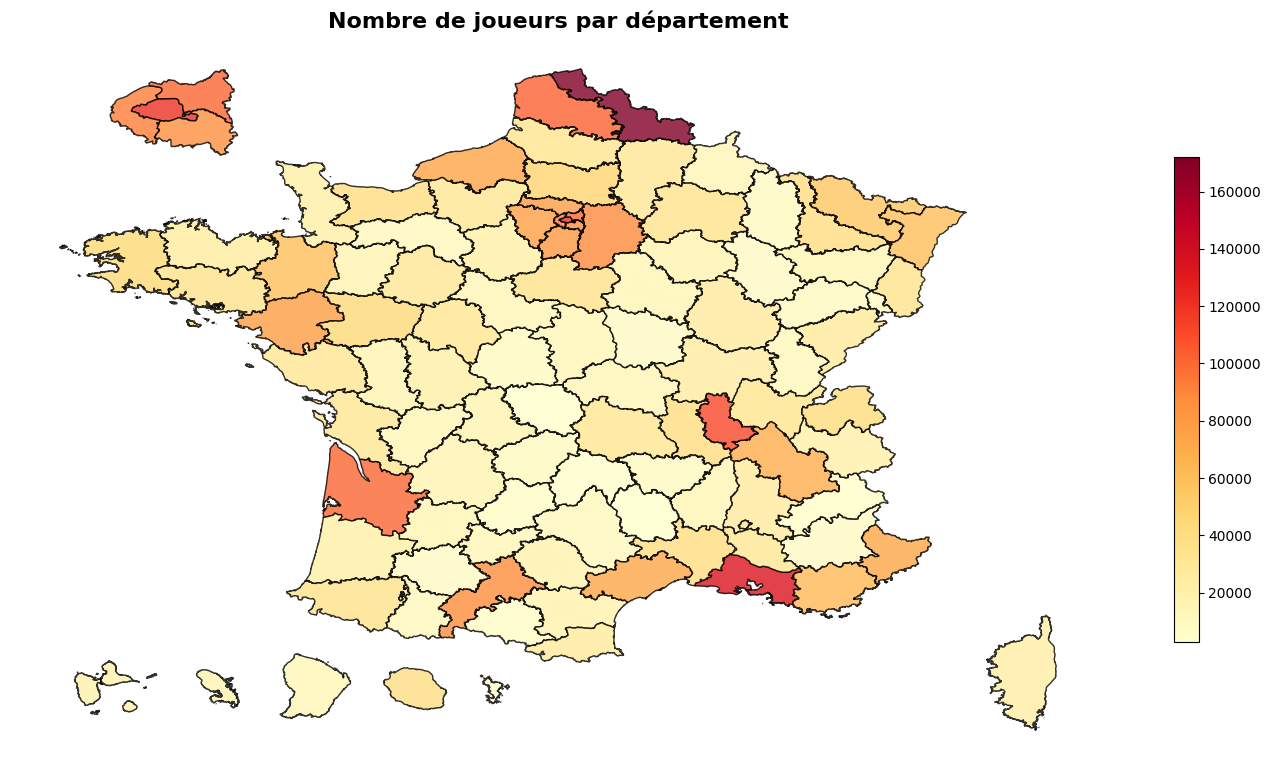

Top 5 des départements avec le plus de joueurs:
         Département  Nombre de Joueurs Uniques tous segments
58              Nord                                 172101.0
12  Bouches-du-Rhône                                 133844.0
74             Paris                                 121106.0
68             Rhône                                 111359.0
61     Pas-de-Calais                                 102169.0


In [34]:
top_5_joueurs = joueurs_geo.nlargest(5, 'Nombre de Joueurs Uniques tous segments')[['Département', 'Nombre de Joueurs Uniques tous segments']]

# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['Nombre de Joueurs Uniques tous segments'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='Nombre de Joueurs Uniques tous segments',
    ax=ax,
    legend=True,
    legend_kwds={'shrink': 0.5},
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs par département', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements avec le plus de joueurs:")
print(top_5_joueurs.to_string())

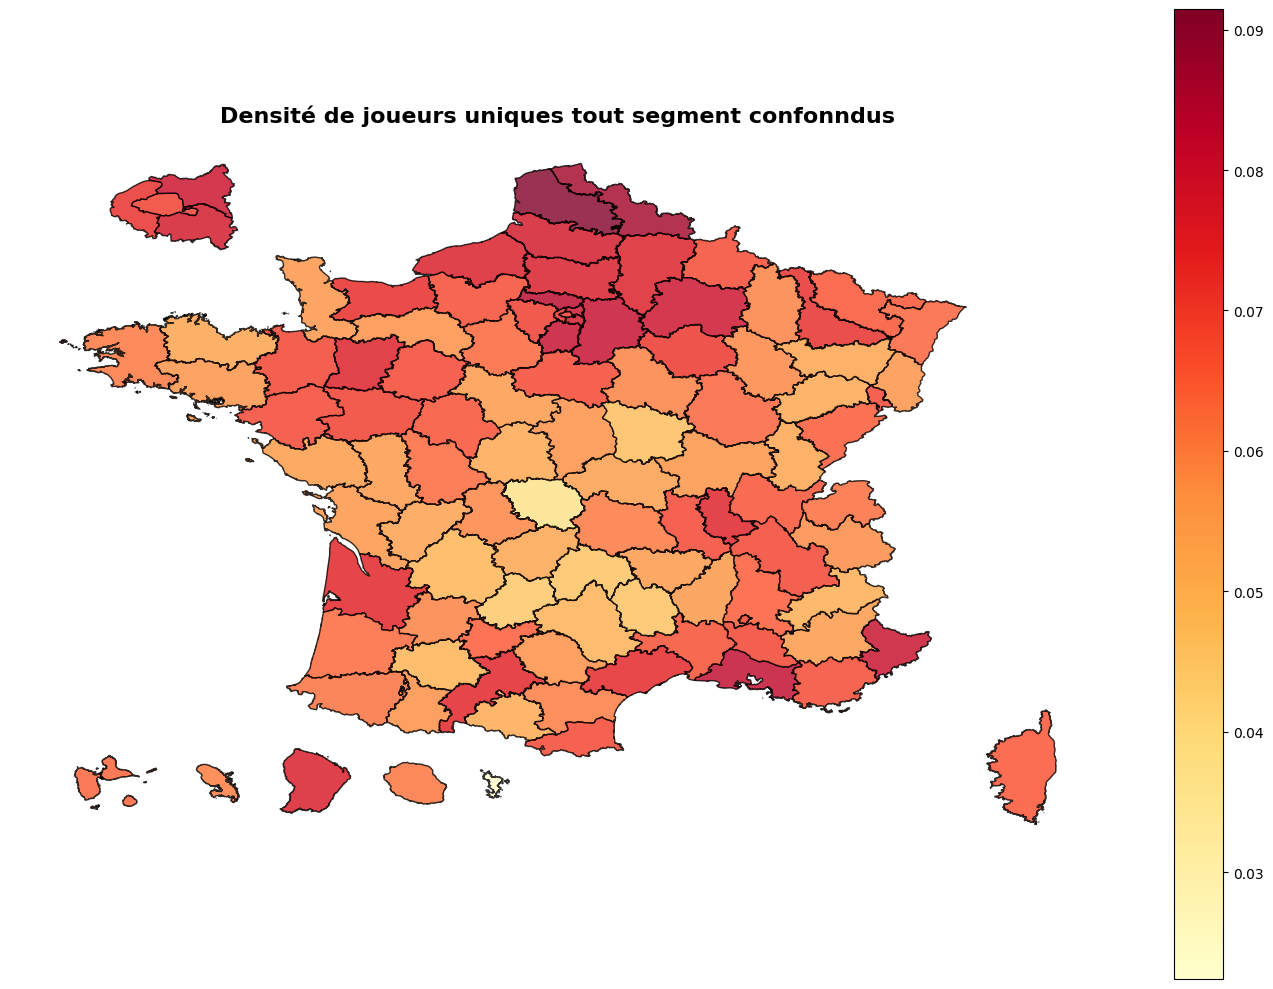

Top 5 des départements avec la plus grosse densité de joueurs:
         Département  Densité joueurs uniques  Nombre de Joueurs Uniques tous segments
61     Pas-de-Calais                 0.091463                                 102169.0
58              Nord                 0.086504                                 172101.0
94        Val-d'Oise                 0.083500                                  78239.0
12  Bouches-du-Rhône                 0.082082                                 133844.0
90           Essonne                 0.081187                                  80896.0


In [35]:
top_5_densité = joueurs_geo.nlargest(5, 'Densité joueurs uniques')[['Département', 'Densité joueurs uniques', 'Nombre de Joueurs Uniques tous segments']]


# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['Densité joueurs uniques'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='Densité joueurs uniques',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Densité de joueurs uniques tout segment confonndus', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements avec la plus grosse densité de joueurs:")
print(top_5_densité.to_string())

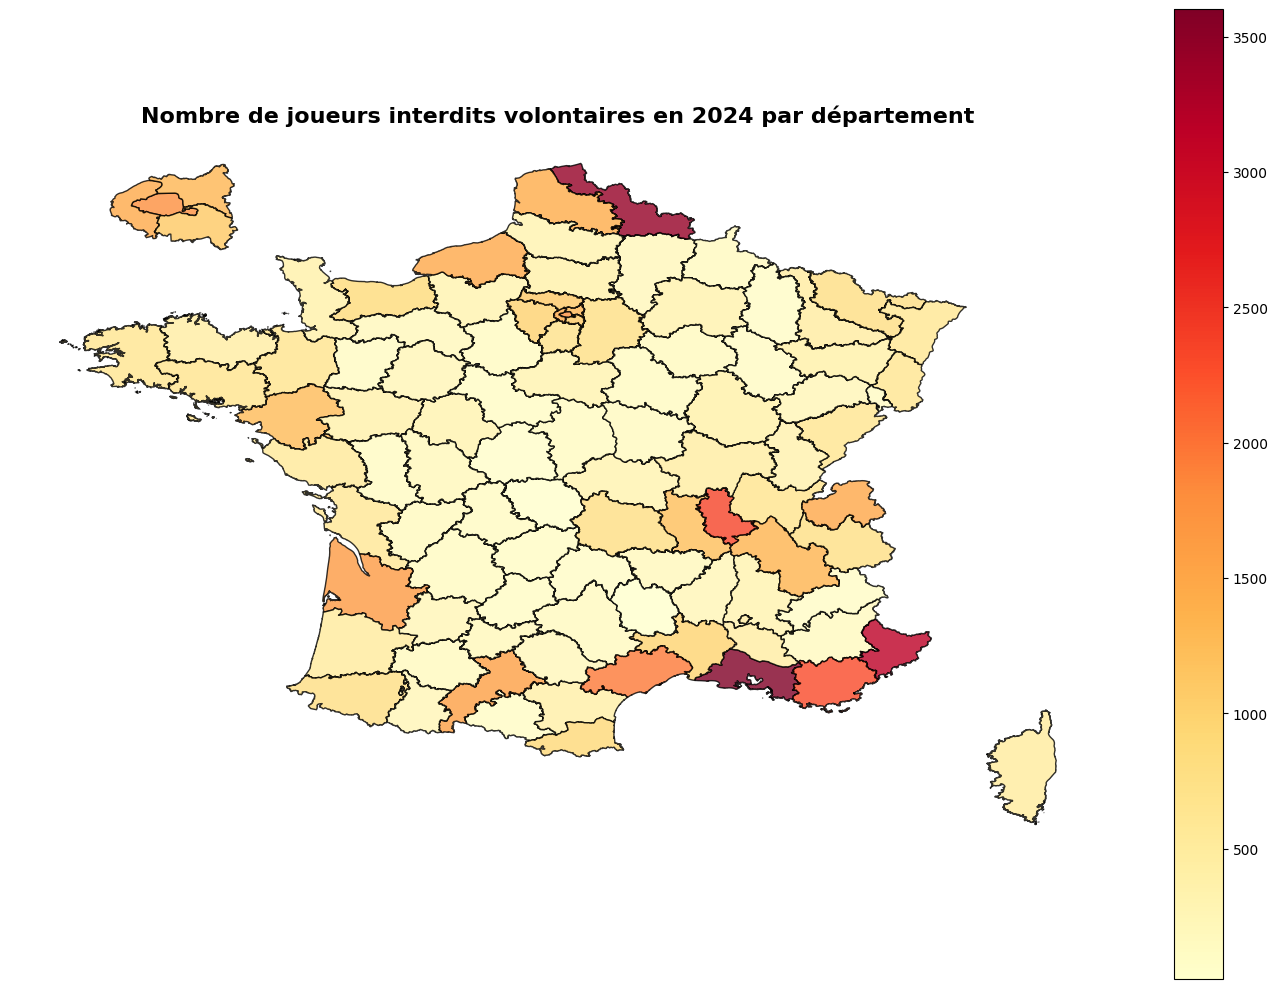

Top 5 des départements avec le plus d'interdits volontaires en 2024:
         Département  nb_interdit_vol_2024
12  Bouches-du-Rhône                3602.0
58              Nord                3435.0
5    Alpes-Maritimes                3150.0
68             Rhône                2367.0
82               Var                2300.0


In [36]:
top_5_interdit = joueurs_geo.nlargest(5, 'nb_interdit_vol_2024')[['Département', 'nb_interdit_vol_2024']]

# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['nb_interdit_vol_2024'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='nb_interdit_vol_2024',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs interdits volontaires en 2024 par département', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements avec le plus d'interdits volontaires en 2024:")
print(top_5_interdit.to_string())

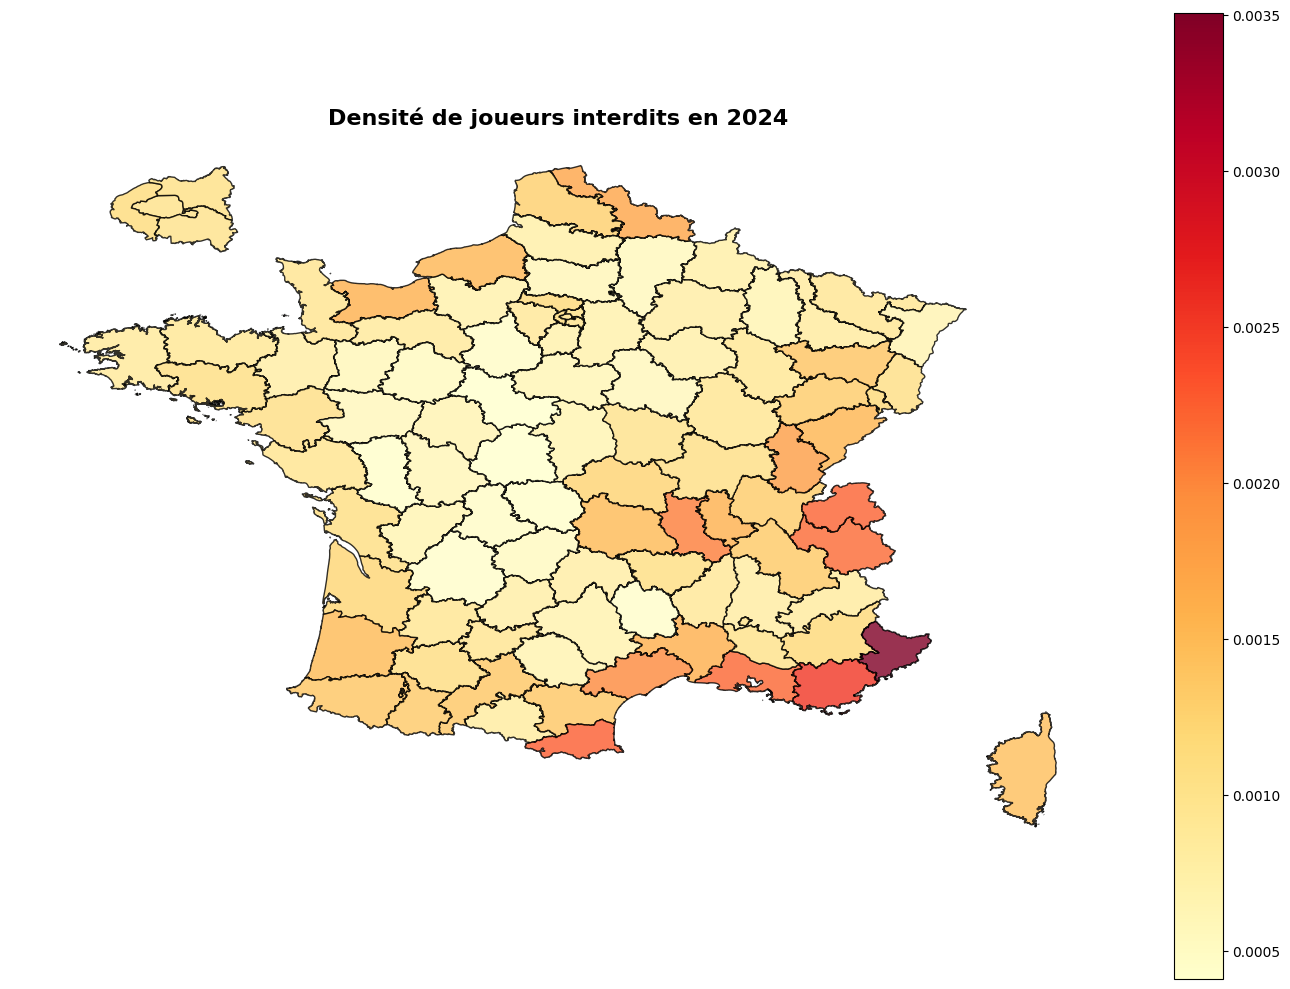

Top 5 des départements avec le plus d'interdits volontaires en 2024:
            Département  densite_interdit_2024  nb_interdit_vol_2024
5       Alpes-Maritimes               0.003505                3150.0
82                  Var               0.002534                2300.0
65  Pyrénées-Orientales               0.002260                 900.0
73         Haute-Savoie               0.002230                1492.0
12     Bouches-du-Rhône               0.002209                3602.0


In [37]:
top_5_interdit = joueurs_geo.nlargest(5, 'densite_interdit_2024')[['Département', 'densite_interdit_2024', 'nb_interdit_vol_2024']]


# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['densite_interdit_2024'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='densite_interdit_2024',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Densité de joueurs interdits en 2024', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements avec le plus d'interdits volontaires en 2024:")
print(top_5_interdit.to_string())

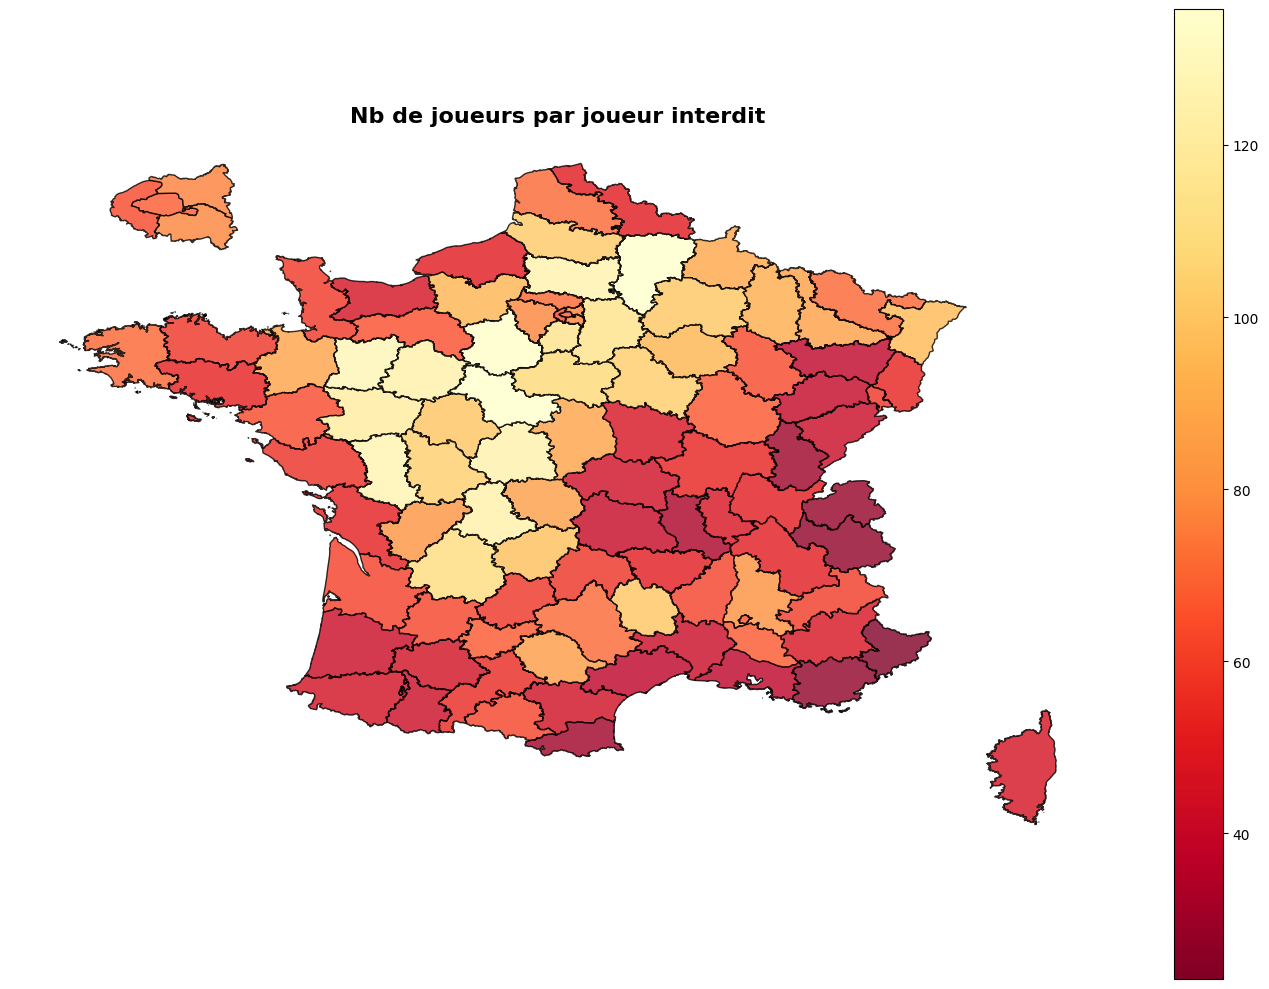

Top 5 des départements avec le moins de joueurs par interdit volontaire en 2024:
        Département  joueurs_pour_interdit  Nombre de Joueurs Uniques tous segments  nb_interdit_vol_2024
5   Alpes-Maritimes              23.060952                                  72642.0                3150.0
72           Savoie              26.584299                                  20656.0                 777.0
82              Var              26.845217                                  61744.0                2300.0
73     Haute-Savoie              28.144772                                  41992.0                1492.0
38             Jura              29.673973                                  10831.0                 365.0


In [38]:
top_5_interdit = joueurs_geo.nsmallest(5, 'joueurs_pour_interdit')[['Département', 'joueurs_pour_interdit', 'Nombre de Joueurs Uniques tous segments', 'nb_interdit_vol_2024']]


# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['joueurs_pour_interdit'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe (rouge pour valeurs faibles)
joueurs_geo_map.plot(
    column='joueurs_pour_interdit',
    ax=ax,
    legend=True,
    cmap='YlOrRd_r',
    edgecolor='k',
    alpha=0.8,
)

ax.set_title('Nb de joueurs par joueur interdit', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements avec le moins de joueurs par interdit volontaire en 2024:")
print(top_5_interdit.to_string())

# DONNEES MARCHES

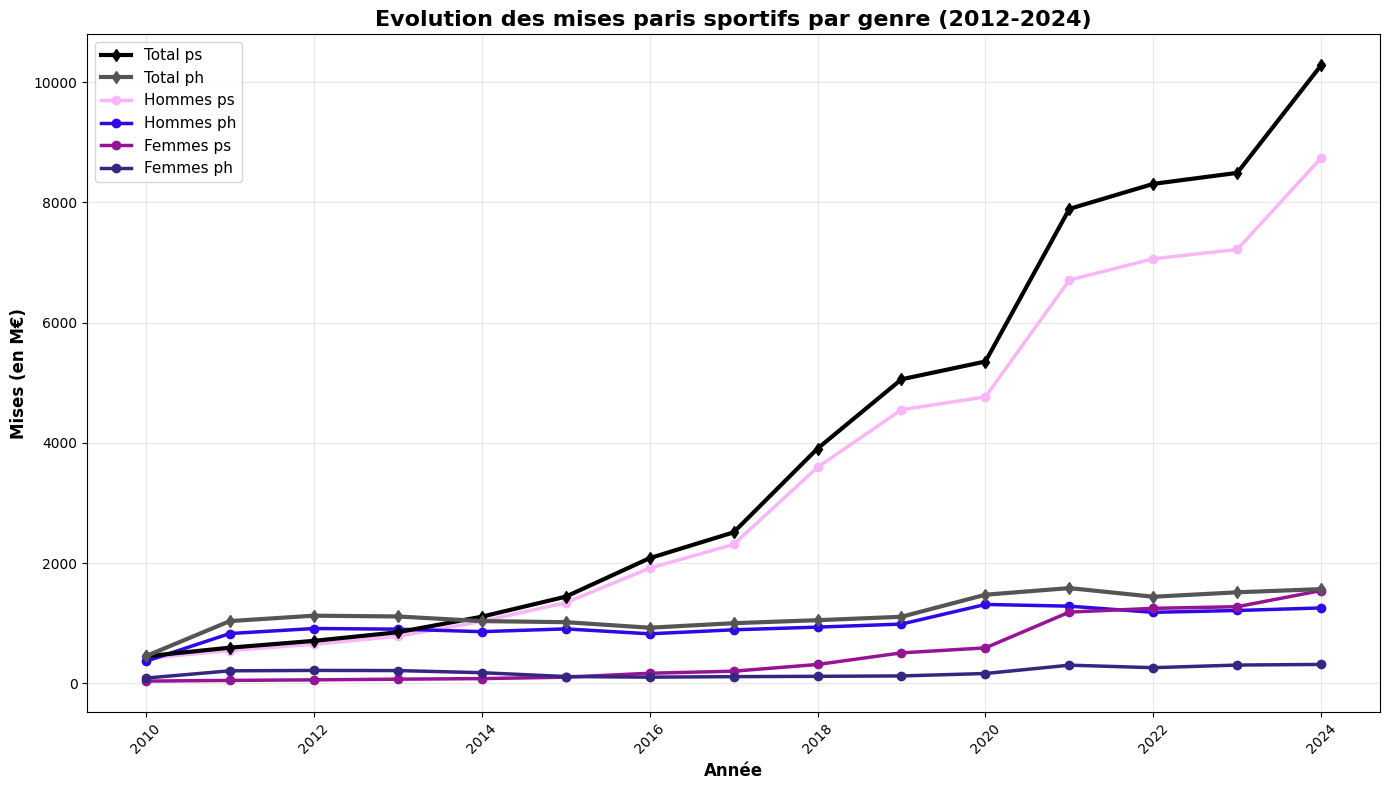

In [ ]:
# Mises par sexe
sexe = ['hommes', 'femmes']
jeu = ['ps', 'ph']
couleurs_sports = ["#F8B6F8", "#3007E6", "#951495", "#372681", "#B958B9", "#291E59"]

fig, ax = plt.subplots(figsize=(14, 8))

# Ajouter la courbe du total
valeurs_ps = marches['mises_ps'].values
valeurs_ph = marches['mises_ph'].values
ax.plot(marches['year'], valeurs_ps, marker='d', linewidth=3, label='Total ps', color='#000000', zorder=10)
ax.plot(marches['year'], valeurs_ph, marker='d', linewidth=3, label='Total ph', color='#555555', zorder=10)

for idx, (sexe_ind, jeu_ind) in enumerate(itertools.product(sexe, jeu)):
    categorie = f'mises_{sexe_ind}_{jeu_ind}'
    if categorie in marches.columns:
        valeurs = marches[categorie].values
        ax.plot(marches['year'], valeurs, marker='o', linewidth=2.5, label=f"{sexe_ind.capitalize()} {jeu_ind}", color=couleurs_sports[idx])
        
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Mises (en M€)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des mises paris sportifs par genre (2010-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Au niveau des cartographies, il est difficile d'en dire quelque chose car il semblerait que le dispositif d'interdit volontaire soit récent et donc pas encore stable. Pour autant, on distingue nettement des départements plus joueurs que d'autres : Nord et Pas-de-Calais, Alpes-Maritimes, Bouches-du-Rhône, Paris et la Savoie --> Trouver des explications à cela